In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from pandas import DataFrame, Series
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error



In [44]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [45]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [46]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8480039,Martin Necas,Necas,C,CAR,82,R,0.610,0.621,0.601,0.597
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.456,0.428,0.401,0.436
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,78,L,0.434,0.441,0.438,0.435
3,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,0.509,0.503,0.487,0.490
4,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,0.463,0.442,0.425,0.466
...,...,...,...,...,...,...,...,...,...,...,...
467,8482652,Walker Duehr,Duehr,R,CGY,40,R,0.437,0.502,0.512,0.429
468,8481553,Bobby Brink,Brink,R,PHI,57,R,0.480,0.489,0.508,0.502
469,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,R,0.518,0.490,0.484,0.509
470,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,L,0.517,0.516,0.537,0.542


In [47]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [48]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [49]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,82,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8475763,Kevin Hayes,Hayes,R,STL,79,2,0,0
3,8471698,T.J. Oshie,Oshie,R,WSH,56,4,0,0
4,8482259,Bobby McMann,McMann,C,TOR,56,0,0,0
...,...,...,...,...,...,...,...,...,...
467,8477940,Nikolaj Ehlers,Ehlers,L,WPG,87,7,1,0
468,8480007,Jonas Rondbjerg,Rondbjerg,R,VGK,20,0,0,0
469,8479981,Jonah Gadjovich,Gadjovich,L,FLA,39,0,0,0
470,8482125,Alexander Holtz,Holtz,R,NJD,82,3,0,0


In [50]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [51]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [52]:
def headshot(row):
    headshot_link = 'https://assets.nhle.com/mugs/nhl/20232024/' + str(row['teamAbbrevs']) + '/' + str(row['playerId']) + '.png'
    return headshot_link

df_players_merged['headshot'] = df_players_merged.apply(headshot, axis=1)

In [53]:
def logo(row):
    logo_link = 'https://assets.nhle.com/logos/nhl/svg/' + str(row['teamAbbrevs']) + '_dark.svg'
    return logo_link

df_players_merged['logo'] = df_players_merged.apply(logo, axis=1)

In [54]:
columns = ['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals']

def percentile(row, column):
    percentile_score = stats.percentileofscore(df_players_merged[column], row[column])
    return percentile_score

for column in columns:
    df_players_merged[column + 'Percentile'] = df_players_merged.apply(lambda row: percentile(row, column), axis = 1)
    df_players_merged[column + 'Percentile'] = df_players_merged[column + 'Percentile'].round(2)

df_players_merged['tiedPercentile'] =  ((df_players_merged['satPercentageTiedPercentile'] + df_players_merged['usatPercentageTiedPercentile']) / 2).round(2)
df_players_merged['closePercentile'] = ((df_players_merged['usatPercentageClosePercentile'] + df_players_merged['satPercentageClosePercentile']) / 2).round(2)
df_players_merged['final'] = (0.3 * df_players_merged['tiedPercentile'] + 0.3 * df_players_merged['closePercentile'] + 0.4 * df_players_merged['gameWinningGoalsPercentile']).round(2)
df_players_merged['finalRank'] = df_players_merged['final'].rank(ascending=False)


In [55]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,logo,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank
0,8480039,Martin Necas,Necas,C,CAR,82,R,61.0,62.1,60.1,...,https://assets.nhle.com/logos/nhl/svg/CAR_dark...,99.15,99.68,98.73,98.31,70.97,99.21,98.73,87.77,29.0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,45.6,42.8,40.1,...,https://assets.nhle.com/logos/nhl/svg/COL_dark...,23.31,11.02,4.03,13.67,37.18,7.52,18.49,22.67,401.0
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,78,L,43.4,44.1,43.8,...,https://assets.nhle.com/logos/nhl/svg/NYI_dark...,11.97,17.06,16.63,13.14,70.97,16.84,12.56,37.21,328.0
3,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,50.9,50.3,48.7,...,https://assets.nhle.com/logos/nhl/svg/STL_dark...,60.17,55.93,43.11,45.76,88.67,49.52,52.96,66.21,125.0
4,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,46.3,44.2,42.5,...,https://assets.nhle.com/logos/nhl/svg/MTL_dark...,26.48,17.37,12.61,29.24,13.45,14.99,27.86,18.24,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,8482652,Walker Duehr,Duehr,R,CGY,40,R,43.7,50.2,51.2,...,https://assets.nhle.com/logos/nhl/svg/CGY_dark...,13.24,54.87,60.70,10.28,13.45,57.78,11.76,26.24,378.0
468,8481553,Bobby Brink,Brink,R,PHI,57,R,48.0,48.9,50.8,...,https://assets.nhle.com/logos/nhl/svg/PHI_dark...,37.50,43.54,57.94,55.40,56.04,50.74,46.45,51.57,233.0
469,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,R,51.8,49.0,48.4,...,https://assets.nhle.com/logos/nhl/svg/ARI_dark...,69.39,44.39,39.83,60.06,70.97,42.11,64.72,60.44,164.0
470,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,L,51.7,51.6,53.7,...,https://assets.nhle.com/logos/nhl/svg/CGY_dark...,68.54,65.15,77.01,85.06,13.45,71.08,76.80,49.74,244.0


In [56]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,472.000000,472.000000,472.000000,472.000000
mean,49.322458,49.365042,49.433051,49.343220
std,4.821401,5.277419,5.431254,4.913502
min,35.700000,34.000000,34.700000,34.400000
50%,49.750000,49.700000,49.500000,49.700000
75%,52.525000,52.900000,53.325000,52.700000
80%,53.080000,53.600000,54.400000,53.460000
90%,55.300000,56.170000,56.190000,55.190000
max,62.300000,62.300000,63.200000,61.600000


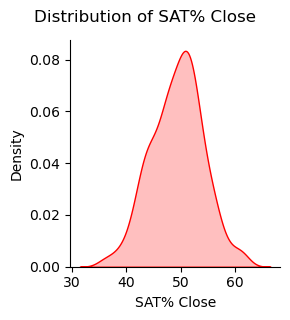

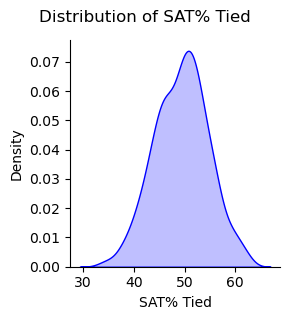

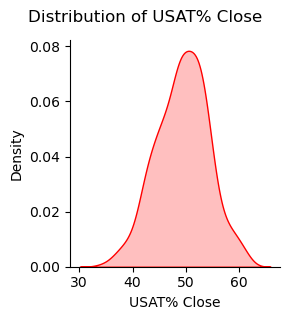

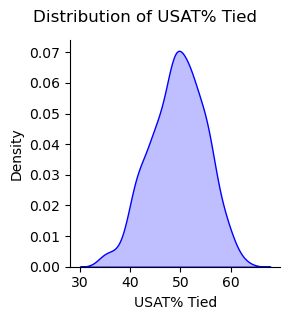

In [57]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageClose', fill=True, color='red')
satClose.fig.suptitle("Distribution of SAT% Close", y = 1.05)
satClose.set_xlabels("SAT% Close")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageTied', fill=True, color='blue')
satTied.fig.suptitle("Distribution of SAT% Tied", y = 1.05)
satTied.set_xlabels("SAT% Tied")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageClose', fill=True, color='red')
usatClose.fig.suptitle("Distribution of USAT% Close", y = 1.05)
usatClose.set_xlabels("USAT% Close")

usatTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageTied', fill=True, color='blue')
usatTied.fig.suptitle("Distribution of USAT% Tied", y = 1.05)
usatTied.set_xlabels("USAT% Tied")

In [58]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,472.000000,472.000000,472.000000
mean,2.239407,0.319915,0.449153
std,2.347672,0.678284,0.848102
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,12.000000,3.000000,6.000000


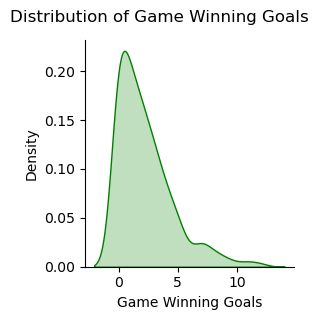

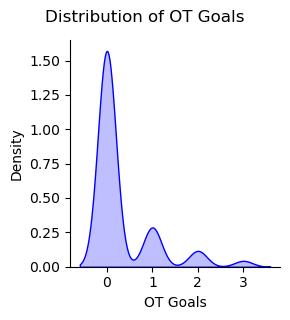

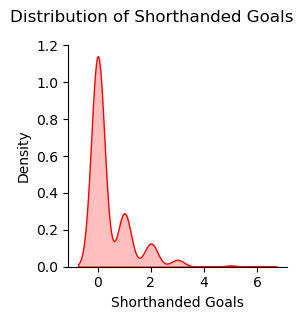

In [59]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'gameWinningGoals', fill=True, color='green')
satClose.fig.suptitle("Distribution of Game Winning Goals", y = 1.05)
satClose.set_xlabels("Game Winning Goals")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'otGoals', fill=True, color='blue')
satTied.fig.suptitle("Distribution of OT Goals", y = 1.05)
satTied.set_xlabels("OT Goals")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'shGoals', fill=True, color='red')
usatClose.fig.suptitle("Distribution of Shorthanded Goals", y = 1.05)
usatClose.set_xlabels("Shorthanded Goals")

In [60]:
gameWinningGoalsQuantile = df_players_merged['gameWinningGoals'].quantile(0.8)

def binary_clutchness(row):
    clutchness = (row['satPercentageClose'] >= 55) or (row['satPercentageTied'] >= 55) or (row['usatPercentageClose'] >= 55) or (row['usatPercentageTied'] >= 55) and (row['gameWinningGoals'] >= gameWinningGoalsQuantile)
    if clutchness:
        return 1
    else:
        return 0
        
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [61]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    385
1     87
Name: count, dtype: int64

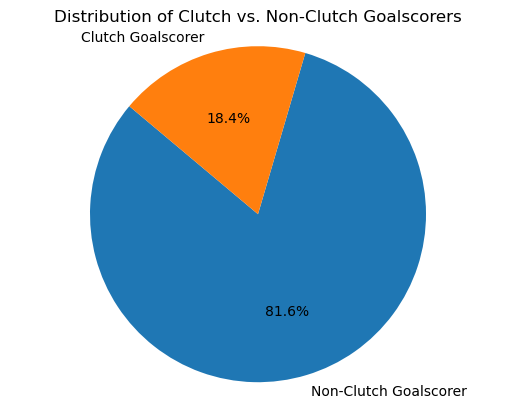

In [62]:
key = ['Non-Clutch Goalscorer', 'Clutch Goalscorer',]

# Create a pie chart
plt.pie(df_players_merged['clutch_performance'].value_counts(), labels=key, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Clutch vs. Non-Clutch Goalscorers')
plt.axis('equal') 
plt.show()

In [63]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.35)
model = RandomForestClassifier(n_estimators=100)
model.fit(train[x_var], train[y_var].values.ravel())

test['clutch_type'] = model.predict(test[x_var])
test['correct'] = (test['clutch_type'] == test['clutch_performance'])

test['correct'].mean()

0.9578313253012049

In [64]:
scores = cross_val_score(model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.        , 0.97916667, 0.9787234 , 0.9787234 , 1.        ,
       0.93617021, 1.        , 1.        , 0.9787234 , 0.9787234 ])

In [65]:
scores.mean()

0.98302304964539

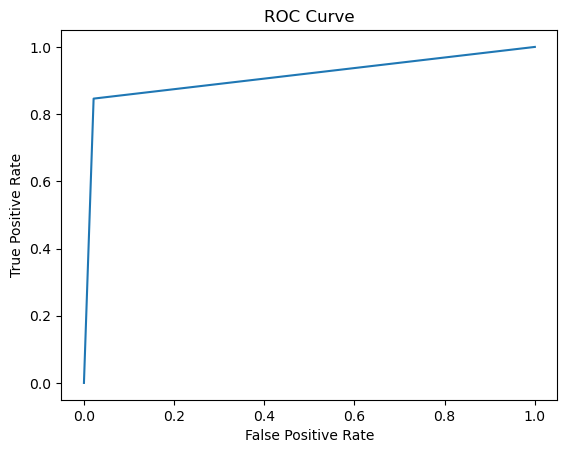

In [66]:
y_pred = model.predict(test[x_var])  
y_true = test[y_var]

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)

display.plot()
plt.title("ROC Curve")
plt.show()

In [67]:
probs = model.predict_proba(test[x_var])[:, 1]

roc_auc = roc_auc_score(test[y_var], probs)

roc_auc

0.9920329670329671

In [68]:
##display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')

In [69]:
y_pred = model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.88
Recall: 0.8461538461538461
F1 Score: 0.8627450980392156


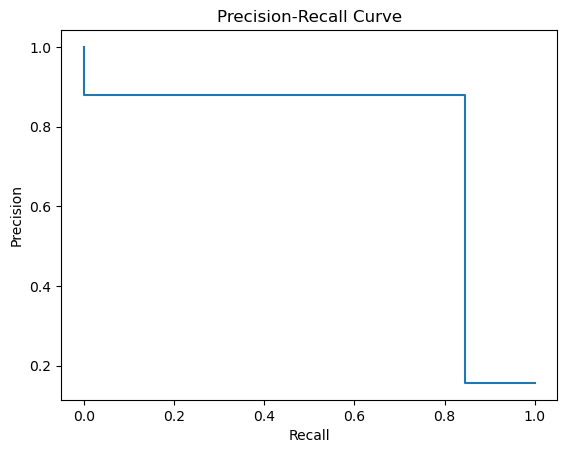

In [70]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

display = PrecisionRecallDisplay(precision=precision, recall=recall)

display.plot()

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

In [71]:
probs = model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probs)

auc_pr

0.9562112717783398

In [72]:
predicted_classes = model.predict(test[x_var])
mcc = matthews_corrcoef(y_true, predicted_classes)
mcc

0.838070271554783

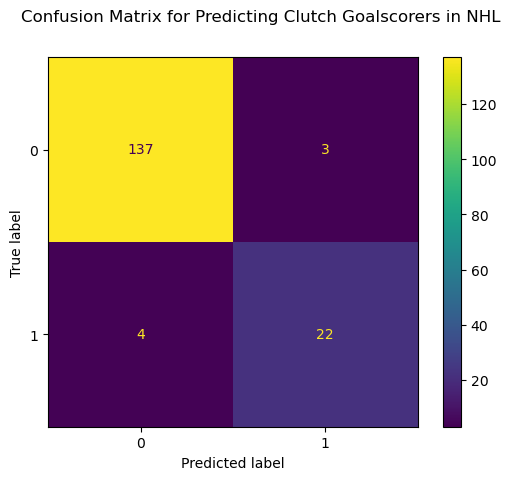

In [73]:
conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for Predicting Clutch Goalscorers in NHL')
plt.show()

In [74]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9578313253012049

In [75]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

train, test = train_test_split(df_players_merged, test_size=0.35)

class_weights = compute_class_weight('balanced', classes=train[y_var].unique(), y=train[y_var])

model = RandomForestClassifier(n_estimators = 100, class_weight = dict(zip(train[y_var].unique(), class_weights)))
model.fit(train[x_var], train[y_var])

accuracy = model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)


Accuracy: 0.963855421686747


In [76]:
cv_scores = cross_val_score(model, df_players_merged[x_var], df_players_merged[y_var], cv=10)

cv_scores

array([0.97916667, 0.97916667, 0.95744681, 0.9787234 , 1.        ,
       0.93617021, 1.        , 1.        , 0.93617021, 0.95744681])

In [77]:
cv_scores.mean()

0.9724290780141844

In [78]:
dict(zip(train[y_var].unique(), class_weights))

{1: 2.732142857142857, 0: 0.612}

In [79]:
mse = mean_squared_error(y_true, y_pred)

mse

0.04216867469879518

In [80]:
df_players_merged['gameWinningGoalsPercentile'] = df_players_merged['gameWinningGoalsPercentile'].astype(str) + '%'
df_players_merged['tiedPercentile'] = df_players_merged['tiedPercentile'].astype(str) + '%'
df_players_merged['closePercentile'] = df_players_merged['closePercentile'].astype(str) + '%'
df_players_merged['final'] = df_players_merged['final'].astype(str) + '%'

In [81]:
df_players_merged.to_csv(r'C:\Users\shakj\Desktop\nhl_clutch_player_data1.csv', index=False)

In [82]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank,clutch_performance
0,8480039,Martin Necas,Necas,C,CAR,82,R,61.0,62.1,60.1,...,99.15,99.68,98.73,98.31,70.97%,99.21%,98.73%,87.77%,29.0,1
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,45.6,42.8,40.1,...,23.31,11.02,4.03,13.67,37.18%,7.52%,18.49%,22.67%,401.0,0
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,78,L,43.4,44.1,43.8,...,11.97,17.06,16.63,13.14,70.97%,16.84%,12.56%,37.21%,328.0,0
3,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,50.9,50.3,48.7,...,60.17,55.93,43.11,45.76,88.67%,49.52%,52.96%,66.21%,125.0,0
4,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,46.3,44.2,42.5,...,26.48,17.37,12.61,29.24,13.45%,14.99%,27.86%,18.24%,420.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,8482652,Walker Duehr,Duehr,R,CGY,40,R,43.7,50.2,51.2,...,13.24,54.87,60.70,10.28,13.45%,57.78%,11.76%,26.24%,378.0,0
468,8481553,Bobby Brink,Brink,R,PHI,57,R,48.0,48.9,50.8,...,37.50,43.54,57.94,55.40,56.04%,50.74%,46.45%,51.57%,233.0,0
469,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,R,51.8,49.0,48.4,...,69.39,44.39,39.83,60.06,70.97%,42.11%,64.72%,60.44%,164.0,0
470,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,L,51.7,51.6,53.7,...,68.54,65.15,77.01,85.06,13.45%,71.08%,76.8%,49.74%,244.0,0


In [83]:
df_players_merged['finalRank'] = df_players_merged['finalRank'].astype(int)

df_players_merged.rename(columns={'skaterFullName': 'Name', 'closePercentile': 'Close Percentile', 'tiedPercentile': 'Tied Percentile', 'closePercentile': 'Close Percentile', 'gameWinningGoalsPercentile': 'GWG Percentile', 'final': 'Clutch Percentile','finalRank': 'Rank'}, inplace=True)

df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'Clutch Percentile', 'GWG Percentile', 'Rank']].sort_values('Rank', ascending=True).head(5)

,Name,Close Percentile,Tied Percentile,Clutch Percentile,GWG Percentile,Rank
197,Sebastian Aho,97.14%,96.45%,97.82%,99.36%,1
57,Seth Jarvis,96.45%,95.76%,96.9%,98.09%,2
339,Zach Hyman,97.08%,96.72%,96.83%,96.72%,3
150,Sam Reinhart,95.12%,95.08%,96.8%,99.36%,4
248,Andrei Svechnikov,98.36%,94.86%,96.65%,96.72%,5


In [84]:
df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'GWG Percentile', 'Clutch Percentile', 'Rank']].sort_values('Rank', ascending=True).head(10)

,Name,Close Percentile,Tied Percentile,GWG Percentile,Clutch Percentile,Rank
197,Sebastian Aho,97.14%,96.45%,99.36%,97.82%,1
57,Seth Jarvis,96.45%,95.76%,98.09%,96.9%,2
339,Zach Hyman,97.08%,96.72%,96.72%,96.83%,3
150,Sam Reinhart,95.12%,95.08%,99.36%,96.8%,4
248,Andrei Svechnikov,98.36%,94.86%,96.72%,96.65%,5
374,Nathan MacKinnon,93.12%,91.48%,98.09%,94.62%,6
170,Leon Draisaitl,90.68%,89.2%,98.09%,93.2%,7
111,Mikko Rantanen,90.26%,88.46%,98.83%,93.15%,8
110,Connor McDavid,97.56%,94.06%,88.67%,92.95%,9
112,Aleksander Barkov,95.24%,95.92%,88.67%,92.82%,10
